# 几何光学 Project： Understand Spherical Aberration

Write codes for generating spot diagrams for lenses.

Only Snell’s Law is simply used. 
Basic system requirements are:

$$
\begin{align}
Aperture\space Diameter &= 30 mm\\
EFL &=100 mm\\
n &= 1.51680\\
Lens\space thickness  &= 7.2 mm\\
\end{align}
$$

Plot spot diagram
Find the minimized GEO (Geometrical radius) on Gaussian image plane.

## 第2问


Optimize lens by changing curvatures $C_1$ and $C_2$, while keeping all others such as EFL and Aperture Diameter no change, to make spot size as small as possible.

#### 几何光学第二问的报告主要分3个部分

#### 1. 实验结果
#### 2. 实验优化部分
#### 3. 实验可视化
#### 4. 实验总结



### 1. 实验结果

当

$$K_1 = 0.00859748mm^{-1}, K_2 = 0.00146219331213883mm^{-1}$$

时，也就是当

$$
c_1 = 0.016635990712074306mm, c_2 = -0.00282932142441725mm
$$

时，实验结果为：

$$
GEO_{min} = 0.358880mm
$$


Ray Tracing的可视化结果（实验未作要求）Spot Diagram的可视化结果分别如下：



In [14]:
from IPython.display import Image
rt2 = Image(filename='./rt2.png')
sd2 = Image(filename='./sd2.png') 

Ray Tracing的结果（实验未作要求）:

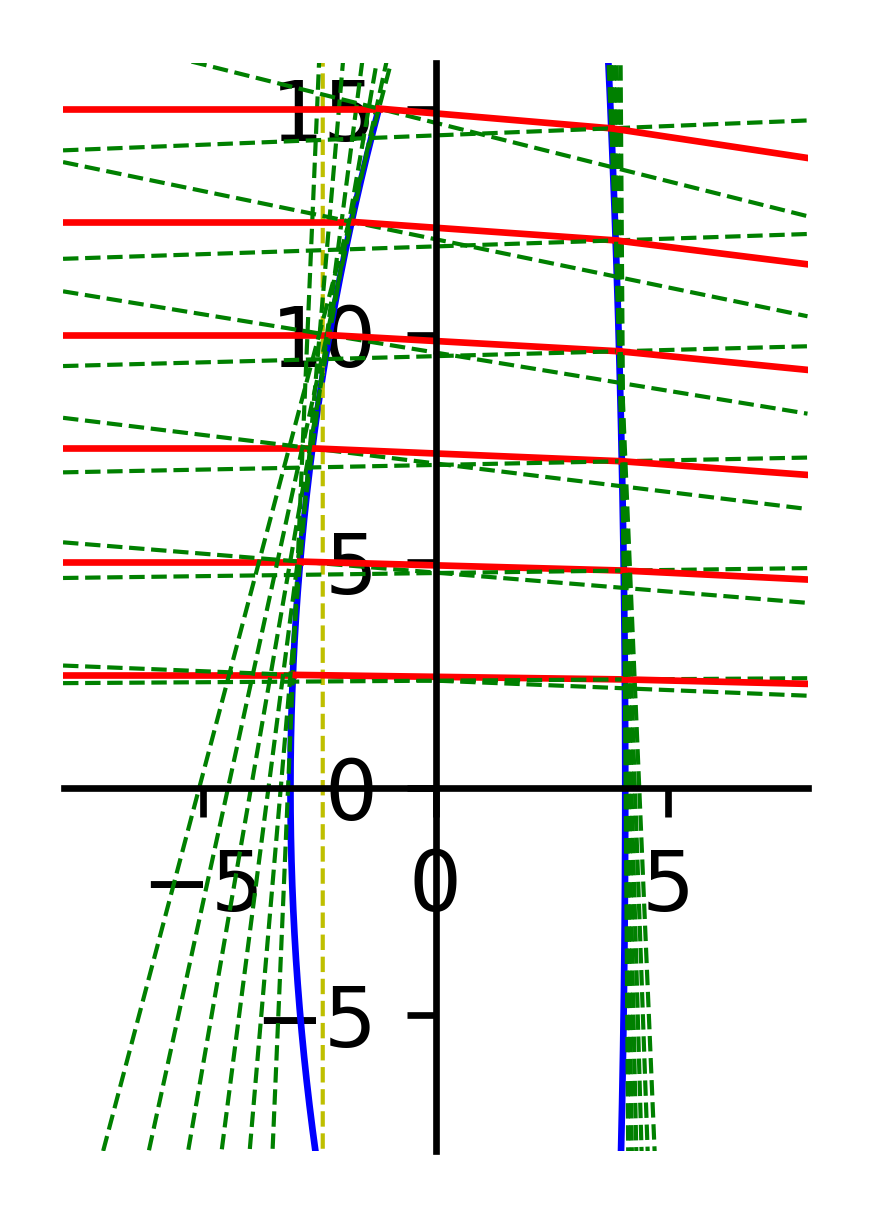

In [15]:
rt2

Spot Diagram的结果:

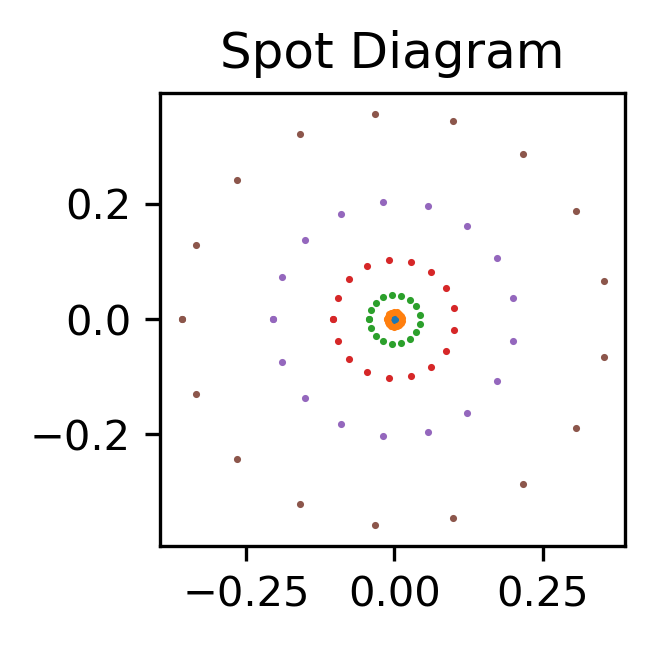

In [16]:
sd2

### 2. 实验优化部分

优化部分采用了scipy包里面的优化器。scipy提供丰富的优化手段。具体可以查看这个[官方文档](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)。

对于本实验而言，看似有两个变量$$C_1, C_2$$ 但实际上两个变量有约束，只有一个自由变量。故使用[sympy直接求导](https://docs.sympy.org/latest/tutorial/calculus.html#derivatives)理论上也可以解决。

对于一个变量的极值问题，求导是极佳的策略。因为一旦得到解析解，那么就可以更精确的求解极值（相比迭代的优化器）。但是迭代优化器（最典型的就是[梯度下降法](https://en.wikipedia.org/wiki/Gradient_descent)，广泛应用于优化，机器学习等领域）的优点是适用面广，对于无法解析求解或者解析求解困难的问题，迭代器可以很好地逼近最优解。

这里采用迭代优化的方法解决。具体采用的算法是[Nelder–Mead method](https://en.wikipedia.org/wiki/Nelder–Mead_method)。

先导入常用的包。和实验1不同的是，我们`from scipy.optimize import *`。里面有我们需要的优化器。

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy.optimize import *

原理部分与实验1类似，在此不赘述。

优化的具体步骤是：

首先我尝试讲$C_1$或者$C_2$作为参量。但是由此解出$K_1, K_2$的过程较繁琐，耗时长，常常出现无解或者得到虚根的现象。如果反设$K_1$或者$K_2$为参量，解出$C_1$或者$C_2$的速度会快很多。且往往只有一个解。

这里我们把$K_1$作为参量。

目标函数的名字是`obj_f`。函数参数为$K_1$，返回值为$GEO$。这是按照优化器的要求设计的。

In [2]:
def obj_f(K1):
    
    K = 1/100
    mu = 1.51680
    d = 7.2
    apt_d = 30
    h = 30

    K2 = sym.Symbol('K_2')
    sol = sym.solve(K1 + K2 - (d/mu)*K1*K2 - K, K2)
    K2 = list(sol.values())[0]

    c1 = K1/(mu - 1)
    c2 = K2/(1 - mu)

    delta_P = -(d*K1)/(mu*K)
    delta   =  (d*K2)/(mu*K)

    # 求解圆心位置
    R1 = 1/c1
    R2 = 1/c2
    C1 = R1 - delta_P - d
    C2 = R2 - delta_P

    x = sym.Symbol('x')

    y0 = float(h/2)
    x0 = C1 - np.sqrt(float(R1**2 - y0**2))
    slope_1 = (C1 - x0)/np.sqrt(float(R1**2 - (-C1 + x0)**2))

    i1   = np.arcsin(float(y0/R1))
    i1_P = np.arcsin(float(y0/R1)/mu)

    theta_1 = i1_P - i1

    slope_2 = np.tan(theta_1)

    x1 = sym.Symbol('x_1')
    y1 = sym.Symbol('y_1')

    def eq(): return sym.sqrt(-(x - C2)**2 + R2**2) - \
    (slope_2*(x - x0) + y0)

    sol = sym.solve(eq(), x)
    if len(sol) == 1:
        x1 = sol[0]
    if len(sol) == 2:
        x1 = sol[1]
    y1 = slope_2*(x1 - x0) + y0

    # print(R2**2 - (-C2 + x1)**2)
    slope_3 = (C2 - x1)/np.sqrt(float(R2**2 - (-C2 + x1)**2))

    # 第二个折射面的入射角
    theta_2 = -theta_1 + np.arctan(float(-1/slope_3))

    # 第二个折射面的折射角
    theta_2P = np.arcsin(mu*np.sin(theta_2))

    np.arctan(float(-1/slope_3)) - theta_2P

    # 经由第二个折射面折射所得的光线的斜率
    slope = np.tan(np.arctan(float(-1/slope_3)) - theta_2P)

    r = abs(slope*(1/K - x1) + y1)

    return r


下面就是优化的过程了：

In [3]:
res = minimize(obj_f, 0.008, method='nelder-mead', \
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.358880
         Iterations: 17
         Function evaluations: 34


上面提示优化成功，说明得到了全局最优解！
在以$K_1 = 0.008$为初始值的时候，经过17次迭代，可得到最优解为：

$$
GEO = 0.358880
$$

迭代优化器的迭代次数对初始值的依赖很大。事实上，有的迭代器（例如实验3使用的）在得到局部最优解后就会停止迭代。所以在选用迭代器的时候，要理解其原理。对于容易得到局部最优的迭代优化器而言，最好采用多个不同的初始值实验，并比较结果。以增加得到全局最优解的概率。

这里我们不需要考虑这个问题。对本实验Nelder–Mead method可得到全局最优解。



### 3. 实验结果可视化

#### 可视化分两部分，一是Ray Tracing，而是Spot Diagram

代码与实验1一样。比较多而且效率低。在实验3将加以改进。

In [5]:
# 建立一个var类，用于变量的值和代数表达式。
class var():
    def __init__(self, str):
        self.s = sym.Symbol(str)
        self.v = None

In [11]:
x = var('x')
K = var('K')
n = var('n')
d = var('d')
apt_d = var('AD')
mu = n
c1, c2 = var('c_1'), var('c_2')
R1, R2 = var('R_1'), var('R_2')
K1, K2 = var('K_1'), var('K_2')
delta, delta_P = var('delta'), var('\delta^{\prime}')

K.v = 1/100.0
n.v = 1.5168
d.v = 7.2
apt_d.v = 30
K1.v = 0.00859748


K2 = var('K_2')
sol = sym.solve(K1.v + K2.s - (d.v/mu.v)*K1.v*K2.s - K.v, K2.s)
K2.v = sol[0]
print(K2.v)

c1.v = K1.v/(mu.v - 1)
c2.v = K2.v/(1 - mu.v)

print(c1.v, c2.v)

0.00146219331213883
0.016635990712074306 -0.00282932142441725


In [7]:
delta_P.v = -(d.v*K1.v)/(mu.v*K.v)
delta.v   = (d.v*K2.v)/(mu.v*K.v)

C1, C2 = var('C_1'), var('C_2')
R1.v = 1/c1.v
R2.v = 1/c2.v
C1.v = R1.v - delta_P.v - d.v
C2.v = R2.v - delta_P.v

print(C1.v, C2.v)

theta = var('theta')
def eq1(get_sym=True): return R1.s*sym.sin(theta.s) - apt_d.s/2 if get_sym \
    else R1.v*sym.sin(theta.s) - apt_d.v/2

def eq2(get_sym=True): return R1.s*sym.sin(theta.s) + apt_d.s/2 if get_sym \
    else R1.v*sym.sin(theta.s) + apt_d.v/2

_, theta_lower = sym.solve(eq1(False), theta.s)
_, theta_upper = sym.solve(eq2(False), theta.s)
theta_lower = float(theta_lower)
theta_upper = float(theta_upper)

x0 = var('x_0')
y0 = var('y_0')
expr = sym.sqrt(R1.s**2 - (x0.s - C1.s)**2)
sym.diff(expr, x0.s)

y0.v = float(15)
x0.v = C1.v - np.sqrt(float(R1.v**2 - y0.v**2))
slope_1 = (C1.v - x0.v)/np.sqrt(float(R1.v**2 - (-C1.v + x0.v)**2))
print(-1/slope_1)

i1   = np.arcsin(float(y0.v/R1.v))
i1_P = np.arcsin(float(y0.v/R1.v)/n.v)

theta_1 = i1_P - i1
slope_2 = np.tan(theta_1)

x1 = var('x_1')
y1 = var('y_1')

def eq(): return sym.sqrt(-(x.s - C2.v)**2 + R2.v**2) - \
(slope_2*(x.s - x0.v) + y0.v)

x1.v = sym.solve(eq(), x.s)[1]
y1.v = slope_2*(x1.v - x0.v) + y0.v

slope_3 = (C2.v - x1.v)/np.sqrt(float(R2.v**2 - (-C2.v + x1.v)**2))
print(-1/slope_3)

# 第二个折射面的入射角
theta_2 = -theta_1 + np.arctan(float(-1/slope_3))

# 第二个折射面的折射角
theta_2P = np.arcsin(n.v*np.sin(theta_2))

np.arctan(float(-1/slope_3)) - theta_2P

# 经由第二个折射面折射所得的光线的斜率
slope = np.tan(np.arctan(float(-1/slope_3)) - theta_2P)

print(abs((slope*(1/K.v - x1.v) + y1.v)))

56.99171934887838 -349.360556189997
-0.2576920711361646
0.0412423413201249
0.358879990040368


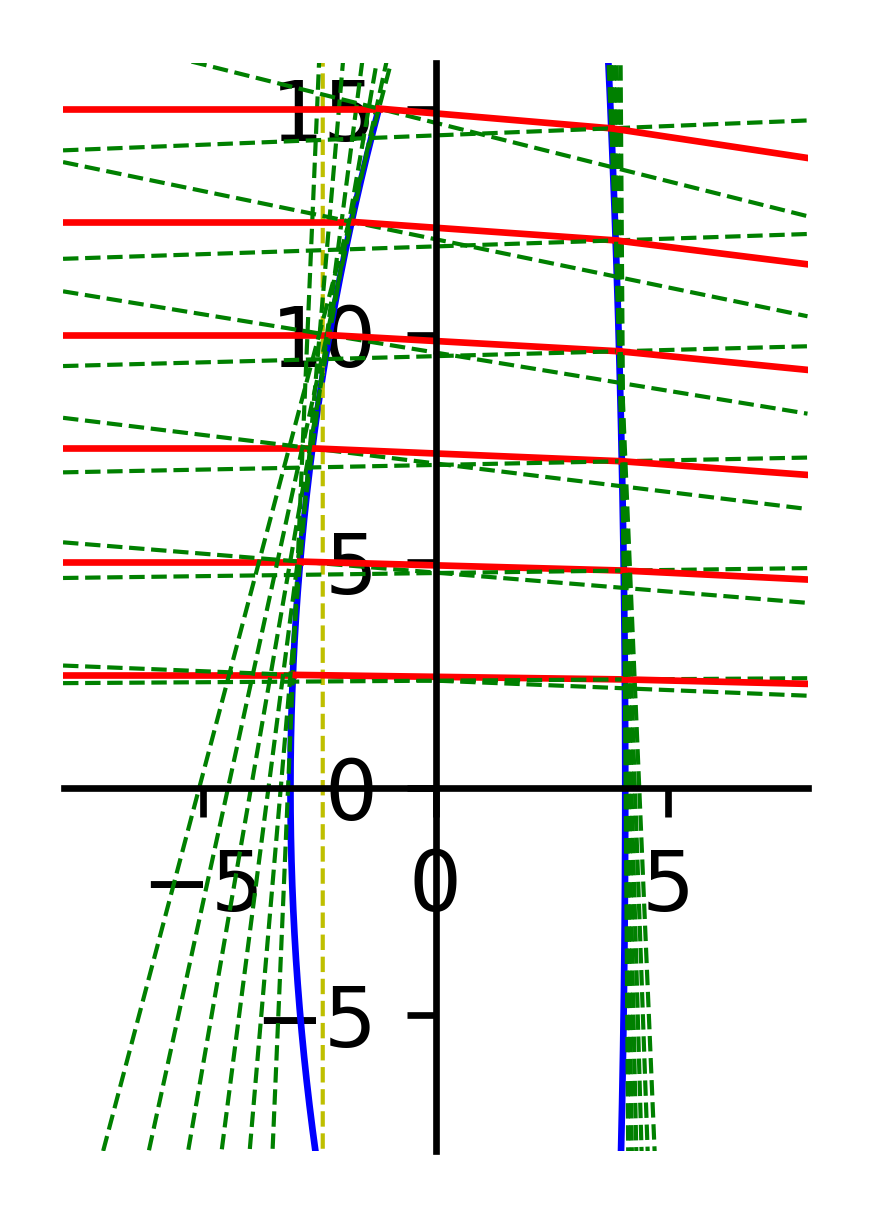

CPU时间(cpu time): 163.74425700000003 s


In [10]:
import time

cpu_start = time.clock()  

# 设置画布
plt.figure(figsize=(1.6, 2.4), dpi=600)
plt.xlim((-8, 8))
plt.ylim((-8, 16))

# 设置坐标轴属性
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'  ].set_position(('data',0))


# 以下是透镜相关的可视化部分

# 描述两圆的角度范围，透镜的左右面范围
ang = np.arange(theta_lower, theta_upper, 0.0005)
# 描述透镜上下底面范围
ll0 = np.arange(C1.v+ R1.v*np.cos(theta_lower), C2.v+ R2.v*np.cos(theta_lower), 0.01)
# 描述各个面切线和法线的范围，即全明面
xx0 = np.arange(-30, 30, 0.01)



# 两圆相交所得透镜的折射面方程
plt.plot(C1.v + R1.v*np.cos(ang), R1.v*np.sin(ang), 'b', linewidth=0.8)
plt.plot(C2.v + R2.v*np.cos(ang), R2.v*np.sin(ang), 'b', linewidth=0.8)

# 透镜的上面和下面，由直线方程描述。
plt.plot(ll0, apt_d.v/2 + 0*ll0, 'b', linewidth=0.8)
plt.plot(ll0, -apt_d.v/2 + 0*ll0, 'b', linewidth=0.8)

# 物方主面的方程
plt.plot(-delta_P.v - d.v + delta.v + xx0*0, xx0, 'y--', linewidth=0.5)



def ray_tracing(h=30, plt_ray_tracing=True, plt_spot_diagram=True):
    y0.v = float(h/2)
    x0.v = C1.v - np.sqrt(float(R1.v**2 - y0.v**2))
    slope_1 = (C1.v - x0.v)/np.sqrt(float(R1.v**2 - (-C1.v + x0.v)**2))

    i1   = np.arcsin(float(y0.v/R1.v))
    i1_P = np.arcsin(float(y0.v/R1.v)/n.v)

    theta_1 = i1_P - i1

    slope_2 = np.tan(theta_1)

    x1 = var('x_1')
    y1 = var('y_1')

    def eq(): return sym.sqrt(-(x.s - C2.v)**2 + R2.v**2) - \
    (slope_2*(x.s - x0.v) + y0.v)

    x1.v = sym.solve(eq(), x.s)[1]
    y1.v = slope_2*(x1.v - x0.v) + y0.v

    sym.init_printing()
    expr = sym.sqrt(R2.s**2 - (x1.s - C2.s)**2)
    sym.diff(expr, x1.s)

    sym.init_printing(pretty_print=False)
    expr = sym.sqrt(R2.s**2 - (x1.s - C2.s)**2)
    sym.diff(expr, x1.s)

    slope_3 = (C2.v - x1.v)/np.sqrt(float(R2.v**2 - (-C2.v + x1.v)**2))

    # 第二个折射面的入射角
    theta_2 = -theta_1 + np.arctan(float(-1/slope_3))

    # 第二个折射面的折射角
    theta_2P = np.arcsin(n.v*np.sin(theta_2))

    np.arctan(float(-1/slope_3)) - theta_2P

    # 经由第二个折射面折射所得的光线的斜率
    slope = np.tan(np.arctan(float(-1/slope_3)) - theta_2P)
    
    r = slope*(1/K.v - x1.v) + y1.v
    
    # 以下是光线Ray Tracing的可视化部分
    
    # 描述入射光x取值范围
    xx1 = np.arange(-30, x0.v, 0.01)
    # 描述第一次折射后，折射光x的取值范围
    xx1P = np.arange(x0.v, x1.v, 0.001)
    # 描述第二次折射后，折射光x的取值范围
    xx2 = np.arange(x1.v, 120, 0.001)
    
    # 入射光方程
    plt.plot(xx1,  y0.v + 0*xx1, 'r', linewidth=0.8)

    # 第一个折射面，入射点处，切线和法线的方程。
    plt.plot(xx0, slope_1*(xx0 - x0.v) + y0.v, 'g--', linewidth=0.5)
    plt.plot(xx0, (-1/slope_1)*(xx0 - x0.v) + y0.v, 'g--', linewidth=0.5)

    # 发生第一次折射后，折射光的方程。
    plt.plot(xx1P, slope_2*(xx1P - x0.v) + y0.v, 'r', linewidth=0.8)

    # 第二个折射面，入射点处，切线和法线的方程。
    plt.plot(xx0, slope_3*(xx0 - x1.v) + y1.v, 'g--', linewidth=0.5)
    plt.plot(xx0, (-1/slope_3)*(xx0 - x1.v) + y1.v, 'g--', linewidth=0.5)

    # 发生第二次折射后，折射光的方程。
    plt.plot(xx2, slope*(xx2 - x1.v) + y1.v, 'r', linewidth=0.8)
    
    return r
    
r_list = []
for h in [5, 10, 15, 20, 25, 30]:
    r_list.append(ray_tracing(h))

plt.show()

cpu_end = time.clock()  
print('CPU时间(cpu time):', cpu_end - cpu_start, 's')
    
 

**以上就是Ray Tracing的可视化结果。其中：**

**蓝色线为透镜**

**黄色线为主面**

**绿色虚线为切线和法线**

**红色线为光线**

除了做出Ray Tracing的可视化结果以外，我同样记录了CPU的运行时间。这里CPU时间为164s。

**记录CPU时间的原因是，复杂度和运行时间也是衡量算法的重要指标。后面将使用改进的算法解决更复杂的第三问可视化问题，并将两者的CPU时间进行比较。**

In [ ]:
下面是Spot Diagram的代码的可视化结果。单位为mm。

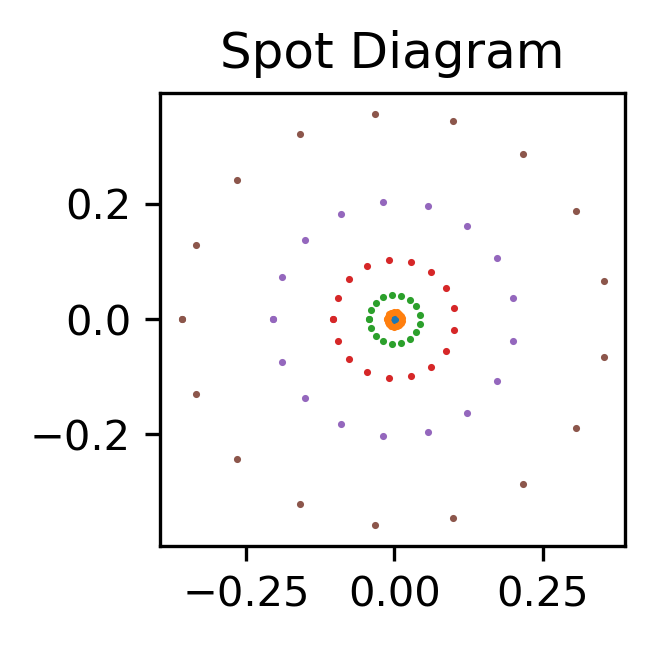

In [9]:
ang = np.linspace(0, 2*np.pi, 18)

plt.figure(figsize=(2, 2), dpi=300)

area = 0.5

for r in r_list:
    plt.scatter(r*np.cos(ang), r*np.sin(ang), s=area, marker='o')
    plt.title('Spot Diagram')
plt.show()

### 4. 实验总结

**这是光学Project的第二个小实验。主要学习实践了优化的过程。报告相对实验1精简了一些。但是代码结构没有根本性的改变。这些缺点将在实验3中加以改进。**